In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,KBinsDiscretizer,LabelEncoder
from sklearn.metrics import mean_squared_error,f1_score
from sklearn.kernel_approximation import Nystroem

from sklearn.model_selection import StratifiedKFold

from catboost import Pool, cv,CatBoostClassifier,CatBoostRegressor

from tqdm import tqdm

In [2]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [3]:
data = train_df[train_df['label'] == 1].dropna()

In [4]:
params = {
    'loss_function':'RMSE',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'RMSE'
}

# Fare

In [5]:
train_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_date,pickup_hour,pickup_minute,drop_date,...,drop_minute,pick_cluster,is_more_than_one_day,distance_km,fare_per_km,pickup_timeslot,day_of_week,is_weekday,cal_time_difference,label
0,10.5,834.0,56.0,0.0000,64.0,270.32,1,0,20,1,...,34,0,0,5.072065,53.190982,0,4,1,6.0,1
1,10.5,791.0,47.0,0.0000,134.0,197.85,1,0,56,1,...,9,0,0,3.151780,62.575517,0,4,1,-11.0,1
2,10.5,1087.0,80.0,0.0000,61.0,301.64,1,1,8,1,...,26,0,0,6.302418,47.785178,0,4,1,-7.0,1
3,10.5,598.0,271.0,15.6638,68.0,82.30,1,2,27,1,...,37,0,0,0.862654,94.309954,0,4,1,2.0,1
4,10.5,3407.0,182.0,0.0000,112.0,1065.02,1,5,38,1,...,35,0,0,24.078955,44.211964,3,4,1,13.0,1


In [6]:
train_df.corr()['fare']

additional_fare              0.315286
duration                     0.865257
meter_waiting                0.870129
meter_waiting_fare           0.865076
meter_waiting_till_pickup    0.045468
fare                         1.000000
pickup_date                  0.016352
pickup_hour                 -0.008770
pickup_minute                0.002625
drop_date                    0.014944
drop_hour                    0.000965
drop_minute                 -0.003325
pick_cluster                -0.043401
is_more_than_one_day         0.402437
distance_km                  0.345672
fare_per_km                  0.161997
pickup_timeslot              0.023294
day_of_week                  0.005104
is_weekday                  -0.005591
cal_time_difference         -0.759984
label                       -0.183854
Name: fare, dtype: float64

In [7]:
cols = ['duration','meter_waiting','meter_waiting_fare','is_more_than_one_day']

In [8]:
X = data[cols].values
y = data['fare'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [10]:
folds = 3

In [11]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))

    model = LinearRegression()
#     model = SVR()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 96.5273471319087
RMSE: 82.29682215032592
RMSE: 82.63358797352826


In [12]:
np.mean(validation_scores)

87.15258575192097

In [13]:
train_df['predicted_fare'] = train_preds
test_df['predicted_fare'] = test_preds

In [14]:
train_df['predicted_fare_diff'] = train_df['fare'] - train_df['predicted_fare']
test_df['predicted_fare_diff'] = test_df['fare'] - test_df['predicted_fare']    

In [15]:
train_df['predicted_fare_diff_per_fare'] = train_df['predicted_fare_diff'] / (train_df['fare']+1)
test_df['predicted_fare_diff_per_fare'] = test_df['predicted_fare_diff'] / (test_df['fare']+1)

In [16]:
train_df['predicted_fare_diff_per_predicted_fare'] = train_df['predicted_fare_diff'] / (train_df['predicted_fare']+1)
test_df['predicted_fare_diff_per_predicted_fare'] = test_df['predicted_fare_diff'] / (test_df['predicted_fare']+1)

In [17]:
train_df['fare_per_distance'] = train_df['fare'] / (train_df['distance_km']+1)
test_df['fare_per_distance'] = test_df['fare'] / (test_df['distance_km']+1)

In [18]:
train_df['predicted_fare_per_distance'] = train_df['predicted_fare'] / (train_df['distance_km']+1)
test_df['predicted_fare_per_distance'] = test_df['predicted_fare'] / (test_df['distance_km']+1)

In [19]:
train_df['predicted_fare_diff_per_distance'] = train_df['predicted_fare_diff'] / (train_df['distance_km']+1)
test_df['predicted_fare_diff_per_distance'] = test_df['predicted_fare_diff'] / (test_df['distance_km']+1)

In [20]:
train_df['predicted_fare_diff_per_fare'] = train_df['predicted_fare_diff'] / (train_df['fare']+1)
test_df['predicted_fare_diff_per_fare'] = test_df['predicted_fare_diff'] / (test_df['fare']+1)

# Duration

In [21]:
train_df.corr()['duration']

additional_fare                          -0.000774
duration                                  1.000000
meter_waiting                             0.969788
meter_waiting_fare                        0.968667
meter_waiting_till_pickup                 0.040576
fare                                      0.865257
pickup_date                               0.009539
pickup_hour                              -0.005981
pickup_minute                             0.001978
drop_date                                 0.007498
drop_hour                                -0.005461
drop_minute                              -0.001219
pick_cluster                             -0.025028
is_more_than_one_day                      0.430620
distance_km                               0.133257
fare_per_km                               0.075521
pickup_timeslot                           0.001819
day_of_week                              -0.003263
is_weekday                                0.002052
cal_time_difference            

In [22]:
cols = ['meter_waiting','meter_waiting_fare','fare','is_more_than_one_day','cal_time_difference']

In [23]:
X = data[cols].values
y = data['duration'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [25]:
folds = 3

In [26]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 412.05683862976997
RMSE: 332.70147883644177
RMSE: 343.7877005393285


In [27]:
np.mean(validation_scores)

362.8486726685134

In [28]:
train_df['predicted_duration'] = train_preds
test_df['predicted_duration'] = test_preds

In [29]:
train_df['predicted_duration_diff'] = train_df['duration'] - train_df['predicted_duration']
test_df['predicted_duration_diff'] = test_df['duration'] - test_df['predicted_duration']    

In [30]:
train_df['predicted_duraton_diff_per_duraton'] = train_df['predicted_duration_diff'] / (train_df['duration']+1)
test_df['predicted_duraton_diff_per_duraton'] = test_df['predicted_duration_diff'] / (test_df['duration']+1)

In [31]:
train_df['predicted_duraton_diff_per_predicted_duration'] = train_df['predicted_duration_diff'] / (train_df['predicted_duration']+1)
test_df['predicted_duraton_diff_per_predicted_duration'] = test_df['predicted_duration_diff'] / (test_df['predicted_duration']+1)

In [32]:
train_df['predicted_duraton_diff_per_distance'] = train_df['predicted_duration_diff'] / (train_df['distance_km']+1)
test_df['predicted_duraton_diff_per_distance'] = test_df['predicted_duration_diff'] / (test_df['distance_km']+1)

In [33]:
train_df['fare_per_duration'] = train_df['fare'] / (train_df['duration']+1)
test_df['fare_per_duration'] = test_df['fare'] / (test_df['duration']+1)

In [34]:
train_df['predicted_fare_per_duration'] = train_df['predicted_fare'] / (train_df['predicted_duration']+1)
test_df['predicted_fare_per_duration'] = test_df['predicted_fare'] / (test_df['predicted_duration']+1)

In [35]:
train_df['predicted_fare_per_duration_diff'] = train_df['fare_per_duration'] - train_df['predicted_fare_per_duration']
test_df['predicted_fare_per_duration_diff'] = test_df['fare_per_duration'] - test_df['predicted_fare_per_duration']

In [36]:
train_df['avg_speed'] = train_df['distance_km'] / (train_df['duration'] + 1)
test_df['avg_speed'] = test_df['distance_km'] / (test_df['duration'] + 1)

In [37]:
train_df['predicted_avg_speed'] = train_df['distance_km'] / (train_df['predicted_duration'] + 1)
test_df['predicted_avg_speed'] = test_df['distance_km'] / (test_df['predicted_duration'] + 1)

In [38]:
train_df['predicted_avg_speed_diff'] = train_df['avg_speed'] - train_df['predicted_avg_speed']
test_df['predicted_avg_speed_diff'] = test_df['avg_speed'] - test_df['predicted_avg_speed']    

# Meter waiting

In [39]:
train_df.corr()['meter_waiting']

additional_fare                                  0.197606
duration                                         0.969788
meter_waiting                                    1.000000
meter_waiting_fare                               0.999474
meter_waiting_till_pickup                        0.030450
fare                                             0.870129
pickup_date                                      0.005620
pickup_hour                                     -0.009111
pickup_minute                                    0.002276
drop_date                                        0.003688
drop_hour                                       -0.015290
drop_minute                                     -0.000628
pick_cluster                                    -0.011850
is_more_than_one_day                             0.412392
distance_km                                      0.046046
fare_per_km                                      0.054659
pickup_timeslot                                  0.008842
day_of_week   

In [40]:
cols = ['duration','meter_waiting_fare','fare','cal_time_difference']

In [41]:
X = data[cols].values
y = data['meter_waiting'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [43]:
folds = 3

In [44]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 121.23549829752587
RMSE: 126.15607547905648
RMSE: 119.87616226350285


In [45]:
np.mean(validation_scores)

122.4225786800284

In [46]:
train_df['predicted_meter_waiting'] = train_preds
test_df['predicted_meter_waiting'] = test_preds

In [47]:
train_df['predicted_meter_waiting_diff'] = train_df['meter_waiting'] - train_df['predicted_meter_waiting']
test_df['predicted_meter_waiting_diff'] = test_df['meter_waiting'] - test_df['predicted_meter_waiting']

In [48]:
train_df['predicted_meter_waiting_diff_per_meter_waiting'] = train_df['predicted_meter_waiting_diff'] / (train_df['meter_waiting'] + 1)
test_df['predicted_meter_waiting_diff_per_meter_waiting'] = test_df['predicted_meter_waiting_diff'] / (test_df['meter_waiting'] + 1)

In [49]:
train_df['predicted_meter_waiting_diff_per_distance'] = train_df['predicted_meter_waiting_diff'] / (train_df['distance_km'] + 1)
test_df['predicted_meter_waiting_diff_per_distance'] = test_df['predicted_meter_waiting_diff'] / (test_df['distance_km'] + 1)

In [50]:
train_df['predicted_meter_waiting_diff_per_predicted_meter_waiting'] = train_df['predicted_meter_waiting_diff'] / (train_df['predicted_meter_waiting'] + 1)
test_df['predicted_meter_waiting_diff_per_predicted_meter_waiting'] = test_df['predicted_meter_waiting_diff'] / (test_df['predicted_meter_waiting'] + 1)

In [51]:
train_df['meter_waiting_per_duration'] = train_df['meter_waiting'] / (train_df['duration']+1)
test_df['meter_waiting_per_duration'] = test_df['meter_waiting'] / (test_df['duration']+1)

In [52]:
train_df['predicted_meter_waiting_per_duration'] = train_df['predicted_meter_waiting'] / (train_df['predicted_duration']+1)
test_df['predicted_meter_waiting_per_duration'] = test_df['predicted_meter_waiting'] / (test_df['predicted_duration']+1)

In [53]:
train_df['predicted_meter_waiting_per_duration_diff'] = train_df['meter_waiting_per_duration'] - train_df['predicted_meter_waiting_per_duration']
test_df['predicted_meter_waiting_per_duration_diff'] = test_df['meter_waiting_per_duration'] - test_df['predicted_meter_waiting_per_duration']

# Meter waiting fare

In [54]:
train_df.corr()['meter_waiting_fare']

additional_fare                                             0.199606
duration                                                    0.968667
meter_waiting                                               0.999474
meter_waiting_fare                                          1.000000
meter_waiting_till_pickup                                   0.029911
fare                                                        0.865076
pickup_date                                                 0.005055
pickup_hour                                                -0.008468
pickup_minute                                               0.002162
drop_date                                                   0.003091
drop_hour                                                  -0.014778
drop_minute                                                -0.000398
pick_cluster                                               -0.010108
is_more_than_one_day                                        0.410323
distance_km                       

In [55]:
cols = ['duration','meter_waiting','fare','is_more_than_one_day','cal_time_difference']

In [56]:
X = data[cols].values
y = data['meter_waiting_fare'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [57]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = scaler.transform(X_train_df)
X_test_df = scaler.transform(X_test_df)

In [58]:
folds = 3

In [59]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))
   
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 7.21561205286957
RMSE: 7.758602065112114
RMSE: 8.8391720955996


In [60]:
np.mean(validation_scores)

7.937795404527095

In [61]:
train_df['predicted_meter_waiting_fare'] = train_preds
test_df['predicted_meter_waiting_fare'] = test_preds

In [62]:
train_df['predicted_meter_waiting_fare_diff'] = train_df['meter_waiting_fare'] - train_df['predicted_meter_waiting_fare']
test_df['predicted_meter_waiting_fare_diff'] = test_df['meter_waiting_fare'] - test_df['predicted_meter_waiting_fare']

In [63]:
train_df['predicted_meter_waiting_fare_diff_per_meter_waiting_fare'] = train_df['predicted_meter_waiting_fare_diff'] / (train_df['meter_waiting_fare']+1)
test_df['predicted_meter_waiting_fare_diff_per_meter_waiting_fare'] = test_df['predicted_meter_waiting_fare_diff'] / (test_df['meter_waiting_fare']+1)

In [64]:
train_df['predicted_meter_waiting_fare_diff_per_distance'] = train_df['predicted_meter_waiting_fare_diff'] / (train_df['distance_km']+1)
test_df['predicted_meter_waiting_fare_diff_per_distance'] = test_df['predicted_meter_waiting_fare_diff'] / (test_df['distance_km']+1)

In [65]:
train_df['predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare'] = train_df['predicted_meter_waiting_fare_diff'] / (train_df['predicted_meter_waiting_fare']+1)
test_df['predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare'] = test_df['predicted_meter_waiting_fare_diff'] / (test_df['predicted_meter_waiting_fare']+1)

In [66]:
train_df['meter_waiting_fare_per_meter_waiting'] = train_df['meter_waiting_fare'] / train_df['meter_waiting']
test_df['meter_waiting_fare_per_meter_waiting'] = test_df['meter_waiting_fare'] / test_df['meter_waiting']

In [67]:
train_df['predicted_meter_waiting_fare_per_meter_waiting'] = train_df['predicted_meter_waiting_fare'] / train_df['predicted_meter_waiting']
test_df['predicted_meter_waiting_fare_per_meter_waiting'] = test_df['predicted_meter_waiting_fare'] / test_df['predicted_meter_waiting']

In [68]:
train_df['predicted_meter_waiting_fare_per_meter_waiting_diff'] = train_df['meter_waiting_fare_per_meter_waiting'] - train_df['predicted_meter_waiting_fare_per_meter_waiting']
test_df['predicted_meter_waiting_fare_per_meter_waiting_diff'] = test_df['meter_waiting_fare_per_meter_waiting'] - test_df['predicted_meter_waiting_fare_per_meter_waiting']

In [69]:
train_df['meter_waiting_fare_per_duration'] = train_df['meter_waiting_fare'] / train_df['duration']
test_df['meter_waiting_fare_per_duration'] = test_df['meter_waiting_fare'] / test_df['duration']

In [70]:
train_df['predicted_meter_waiting_fare_per_duration'] = train_df['predicted_meter_waiting_fare'] / train_df['predicted_duration']
test_df['predicted_meter_waiting_fare_per_duration'] = test_df['predicted_meter_waiting_fare'] / test_df['predicted_duration']

In [71]:
train_df['predicted_meter_waiting_fare_per_duration_diff'] = train_df['meter_waiting_fare_per_duration'] - train_df['predicted_meter_waiting_fare_per_duration']
test_df['predicted_meter_waiting_fare_per_duration_diff'] = test_df['meter_waiting_fare_per_duration'] - test_df['predicted_meter_waiting_fare_per_duration']

# Addtional fare

In [72]:
train_df.corr()['additional_fare']

additional_fare                                                       1.000000
duration                                                             -0.000774
meter_waiting                                                         0.197606
meter_waiting_fare                                                    0.199606
meter_waiting_till_pickup                                             0.002352
fare                                                                  0.315286
pickup_date                                                           0.005820
pickup_hour                                                          -0.005050
pickup_minute                                                        -0.000724
drop_date                                                             0.005830
drop_hour                                                            -0.004708
drop_minute                                                           0.000051
pick_cluster                                        

In [73]:
cols = ['meter_waiting_fare_per_duration','meter_waiting_per_duration','fare_per_duration']

In [74]:
data = train_df[train_df['label'] == 1].dropna()

In [75]:
X = data[cols].values
y = data['additional_fare'].values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [76]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = np.nan_to_num(scaler.transform(X_train_df))
X_test_df = np.nan_to_num(scaler.transform(X_test_df))

In [77]:
folds = 3

In [78]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

#     model = CatBoostRegressor(**params)
#     model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test))
   
    model = LinearRegression()
    model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

RMSE: 8.720292350311684
RMSE: 11.875141951981368
RMSE: 12.088516557325503


In [79]:
train_df['predicted_additional_fare'] = train_preds
test_df['predicted_additional_fare'] = test_preds

In [80]:
train_df['predicted_additional_fare_diff'] = train_df['additional_fare'] - train_df['predicted_additional_fare']
test_df['predicted_additional_fare_diff'] = test_df['additional_fare'] - test_df['predicted_additional_fare']

In [81]:
train_df['predicted_additional_fare_diff_per_additional_fare'] = train_df['predicted_additional_fare_diff'] / (train_df['additional_fare']+1)
test_df['predicted_additional_fare_diff_per_additional_fare'] = test_df['predicted_additional_fare_diff'] / (test_df['additional_fare']+1)

In [82]:
train_df['predicted_addtional_fare_per_fare'] = train_df['predicted_additional_fare'] / (train_df['predicted_fare']+1)
test_df['predicted_addtional_fare_per_fare'] = test_df['predicted_additional_fare'] / (test_df['predicted_fare']+1)

In [83]:
train_df['addtional_fare_per_fare'] = train_df['additional_fare'] / (train_df['fare']+1)
test_df['addtional_fare_per_fare'] = test_df['additional_fare'] / (test_df['fare']+1)

In [84]:
train_df['addtional_fare_per_distance'] = train_df['additional_fare'] / (train_df['distance_km']+1)
test_df['addtional_fare_per_distance'] = test_df['additional_fare'] / (test_df['distance_km']+1)

In [85]:
train_df['predicted_addtional_fare_per_distance'] = train_df['predicted_additional_fare'] / (train_df['distance_km']+1)
test_df['predicted_addtional_fare_per_distance'] = test_df['predicted_additional_fare'] / (test_df['distance_km']+1)

In [86]:
train_df['predicted_addtional_fare_diff_per_distance'] = train_df['predicted_additional_fare_diff'] / (train_df['distance_km']+1)
test_df['predicted_addtional_fare_diff_per_distance'] = test_df['predicted_additional_fare_diff'] / (test_df['distance_km']+1)

In [87]:
train_df['addtional_fare_per_duration'] = train_df['additional_fare'] / (train_df['duration']+1)
test_df['addtional_fare_per_duration'] = test_df['additional_fare'] / (test_df['duration']+1)

In [88]:
train_df['predicted_addtional_fare_per_duration'] = train_df['predicted_additional_fare'] / (train_df['predicted_duration']+1)
test_df['predicted_addtional_fare_per_duration'] = test_df['predicted_additional_fare'] / (test_df['predicted_duration']+1)

In [89]:
train_df['fare-additional_fare'] = train_df['fare'] - train_df['additional_fare']
test_df['fare-additional_fare'] = test_df['fare'] - test_df['additional_fare']

In [90]:
train_df['predicted_fare-additional_fare'] = train_df['predicted_fare'] - train_df['predicted_additional_fare']
test_df['predicted_fare-additional_fare'] = test_df['predicted_fare'] - test_df['predicted_additional_fare']

In [91]:
train_df['fare-additional_fare-meter_waiting_fare'] = train_df['fare'] - (train_df['additional_fare'] + train_df['meter_waiting_fare'])
test_df['fare-additional_fare-meter_waiting_fare'] = test_df['fare'] - (test_df['additional_fare'] + test_df['meter_waiting_fare'])

In [92]:
train_df['predicted_fare-additional_fare-meter_waiting_fare'] = train_df['predicted_fare'] - (train_df['predicted_additional_fare'] + train_df['predicted_meter_waiting_fare'])
test_df['predicted_fare-additional_fare-meter_waiting_fare'] = test_df['predicted_fare'] - (test_df['predicted_additional_fare'] + test_df['predicted_meter_waiting_fare'])

In [93]:
train_df['fare-additional_fare_per_distance'] = train_df['fare-additional_fare'] / (train_df['distance_km']+1)
test_df['fare-additional_fare_per_distance'] = test_df['fare-additional_fare'] / (test_df['distance_km']+1)

In [94]:
train_df['predicted_fare-additional_fare_per_distance'] = train_df['predicted_fare-additional_fare'] / (train_df['distance_km']+1)
test_df['predicted_fare-additional_fare_per_distance'] = test_df['predicted_fare-additional_fare'] / (test_df['distance_km']+1)

In [95]:
train_df['fare-additional_fare_per_duration'] = train_df['fare-additional_fare'] / (train_df['duration']+1)
test_df['fare-additional_fare_per_duration'] = test_df['fare-additional_fare'] / (test_df['duration']+1)

In [96]:
train_df['predicted_fare-additional_fare_per_duration'] = train_df['predicted_fare-additional_fare'] / (train_df['predicted_duration']+1)
test_df['predicted_fare-additional_fare_per_duration'] = test_df['predicted_fare-additional_fare'] / (test_df['predicted_duration']+1)

In [97]:
train_df['fare-additional_fare-meter_waiting_fare_per_distance'] = train_df['fare-additional_fare-meter_waiting_fare'] / (train_df['distance_km']+1)
test_df['fare-additional_fare-meter_waiting_fare_per_distance'] = test_df['fare-additional_fare-meter_waiting_fare'] / (test_df['distance_km']+1)

In [98]:
train_df['predicted_fare-additional_fare-meter_waiting_fare_per_distance'] = train_df['predicted_fare-additional_fare-meter_waiting_fare'] / (train_df['distance_km']+1)
test_df['predicted_fare-additional_fare-meter_waiting_fare_per_distance'] = test_df['predicted_fare-additional_fare-meter_waiting_fare'] / (test_df['distance_km']+1)

In [99]:
train_df['fare-additional_fare-meter_waiting_fare_per_duration'] = train_df['fare-additional_fare-meter_waiting_fare'] / (train_df['duration']+1)
test_df['fare-additional_fare-meter_waiting_fare_per_duration'] = test_df['fare-additional_fare-meter_waiting_fare'] / (test_df['duration']+1)

In [100]:
train_df['predicted_fare-additional_fare-meter_waiting_fare_per_duration'] = train_df['predicted_fare-additional_fare-meter_waiting_fare'] / (train_df['predicted_duration']+1)
test_df['predicted_fare-additional_fare-meter_waiting_fare_per_duration'] = test_df['predicted_fare-additional_fare-meter_waiting_fare'] / (test_df['predicted_duration']+1)

# meter waiting till pickup

In [101]:
train_df.corr()['meter_waiting_till_pickup'].sort_values()

label                                                      -0.035546
cal_time_difference                                        -0.020416
predicted_meter_waiting_fare_diff                          -0.018670
predicted_meter_waiting_fare_diff_per_meter_waiting_fare   -0.017397
meter_waiting_fare_per_meter_waiting                       -0.016903
                                                              ...   
fare-additional_fare-meter_waiting_fare                     0.045641
fare-additional_fare                                        0.046909
predicted_fare-additional_fare                              0.052861
predicted_fare                                              0.054280
meter_waiting_till_pickup                                   1.000000
Name: meter_waiting_till_pickup, Length: 80, dtype: float64

In [102]:
data = train_df[train_df['label'] == 1].dropna()
y = data['meter_waiting_till_pickup'].values
X = data.drop(['label','meter_waiting_till_pickup'],axis=1)
cols = X.columns
X = X.values

X_train_df = train_df[cols].values
X_test_df = test_df[cols].values

In [103]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_df = np.nan_to_num(scaler.transform(X_train_df))
X_test_df = np.nan_to_num(scaler.transform(X_test_df))

In [104]:
folds = 3

In [105]:
validation_scores = []
models = []

train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
kf = KFold(n_splits=folds)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = CatBoostRegressor(**params)
    model.fit(X=X_train,y=y_train,eval_set=(X_test,y_test),verbose=10)
   
#     model = SVR()
#     model.fit(X_train,y_train)
    
    pred = model.predict(X_test)
    score = mean_squared_error(y_test,pred) ** 0.5
    validation_scores.append(score)
    models.append(model)
    print('RMSE:', score)
    
    train_preds += model.predict(X_train_df)
    test_preds += model.predict(X_test_df)
    
train_preds /= folds
test_preds /= folds

Learning rate set to 0.071025
0:	learn: 118.6085647	test: 752.4014533	best: 752.4014533 (0)	total: 70.7ms	remaining: 1m 10s
10:	learn: 115.6279704	test: 751.4615819	best: 751.4615819 (10)	total: 200ms	remaining: 18s
20:	learn: 114.1567627	test: 751.0719888	best: 751.0719888 (20)	total: 290ms	remaining: 13.5s
30:	learn: 113.1604569	test: 750.7494121	best: 750.7494121 (30)	total: 361ms	remaining: 11.3s
40:	learn: 112.3488130	test: 750.3135685	best: 750.3135685 (40)	total: 452ms	remaining: 10.6s
50:	learn: 111.6237013	test: 750.1796473	best: 750.1796473 (50)	total: 523ms	remaining: 9.73s
60:	learn: 110.9276689	test: 750.1443872	best: 750.1353974 (57)	total: 595ms	remaining: 9.15s
70:	learn: 110.3372737	test: 749.9718913	best: 749.9536518 (63)	total: 678ms	remaining: 8.88s
80:	learn: 109.6922453	test: 749.9560205	best: 749.9450179 (72)	total: 761ms	remaining: 8.63s
90:	learn: 109.0438206	test: 749.8348078	best: 749.8250639 (83)	total: 838ms	remaining: 8.37s
100:	learn: 108.4398849	test: 74

In [106]:
np.mean(validation_scores)

329.4998853603019

In [107]:
train_df['predicted_meter_waiting_till_pickup'] = train_preds
test_df['predicted_meter_waiting_till_pickup'] = test_preds

In [108]:
train_df['predicted_meter_waiting_till_pickup_diff'] = train_df['meter_waiting_till_pickup'] - train_df['predicted_meter_waiting_till_pickup']
test_df['predicted_meter_waiting_till_pickup_diff'] = test_df['meter_waiting_till_pickup'] - test_df['predicted_meter_waiting_till_pickup']

In [109]:
train_df['predicted_meter_waiting_till_pickup_diff_per_meter_waiting_till_pickup'] = train_df['predicted_meter_waiting_till_pickup_diff'] / (train_df['meter_waiting_till_pickup']+1)
test_df['predicted_meter_waiting_till_pickup_diff_per_meter_waiting_till_pickup'] = test_df['predicted_meter_waiting_till_pickup_diff'] / (test_df['meter_waiting_till_pickup']+1)

In [110]:
train_df['meter_waiting_till_pickup_per_meter_waiting'] = train_df['meter_waiting_till_pickup'] / (train_df['meter_waiting'] + 1)
test_df['meter_waiting_till_pickup_per_meter_waiting'] = test_df['meter_waiting_till_pickup'] / (test_df['meter_waiting'] + 1)

In [111]:
train_df['predicted_meter_waiting_till_pickup_per_meter_waiting'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['predicted_meter_waiting'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_meter_waiting'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['predicted_meter_waiting'] + 1)

In [112]:
train_df['predicted_meter_waiting_till_pickup_per_meter_waiting_diff'] = train_df['meter_waiting_till_pickup_per_meter_waiting'] - train_df['predicted_meter_waiting_till_pickup_per_meter_waiting']
test_df['predicted_meter_waiting_till_pickup_per_meter_waiting_diff'] = test_df['meter_waiting_till_pickup_per_meter_waiting'] - test_df['predicted_meter_waiting_till_pickup_per_meter_waiting']

In [113]:
train_df['meter_waiting_after_pickup'] = train_df['meter_waiting'] - train_df['meter_waiting_till_pickup']
test_df['meter_waiting_after_pickup'] = test_df['meter_waiting'] - test_df['meter_waiting_till_pickup']

In [114]:
train_df['predicted_meter_waiting_after_pickup'] = train_df['predicted_meter_waiting'] - train_df['predicted_meter_waiting_till_pickup']
test_df['predicted_meter_waiting_after_pickup'] = test_df['predicted_meter_waiting'] - test_df['predicted_meter_waiting_till_pickup']

In [115]:
train_df['meter_waiting_after_pickup_per_duration'] = train_df['meter_waiting_after_pickup'] / (train_df['duration'] + 1)
test_df['meter_waiting_after_pickup_per_duration'] = test_df['meter_waiting_after_pickup'] / (test_df['duration'] + 1)

In [116]:
train_df['predicted_meter_waiting_after_pickup_per_duration'] = train_df['predicted_meter_waiting_after_pickup'] / (train_df['predicted_duration'] + 1)
test_df['predicted_meter_waiting_after_pickup_per_duration'] = test_df['predicted_meter_waiting_after_pickup'] / (test_df['predicted_duration'] + 1)

In [117]:
train_df['meter_waiting_till_pickup_per_duration'] = train_df['meter_waiting_till_pickup'] / (train_df['duration'] + 1)
test_df['meter_waiting_till_pickup_per_duration'] = test_df['meter_waiting_till_pickup'] / (test_df['duration'] + 1)

In [118]:
train_df['predicted_meter_waiting_till_pickup_per_duration'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['predicted_duration'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_duration'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['predicted_duration'] + 1)

In [119]:
train_df['meter_waiting_till_pickup_per_distance'] = train_df['meter_waiting_till_pickup'] / (train_df['distance_km'] + 1)
test_df['meter_waiting_till_pickup_per_distance'] = test_df['meter_waiting_till_pickup'] / (test_df['distance_km'] + 1)

In [120]:
train_df['predicted_meter_waiting_till_pickup_per_distance'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['distance_km'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_distance'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['distance_km'] + 1)

In [121]:
train_df['meter_waiting_after_pickup_per_distance'] = train_df['meter_waiting_after_pickup'] / (train_df['distance_km'] + 1)
test_df['meter_waiting_after_pickup_per_distance'] = test_df['meter_waiting_after_pickup'] / (test_df['distance_km'] + 1)

In [122]:
train_df['predicted_meter_waiting_after_pickup_per_distance'] = train_df['predicted_meter_waiting_after_pickup'] / (train_df['distance_km'] + 1)
test_df['predicted_meter_waiting_after_pickup_per_distance'] = test_df['predicted_meter_waiting_after_pickup'] / (test_df['distance_km'] + 1)

In [123]:
train_df['meter_waiting_till_pickup_per_fare'] = train_df['meter_waiting_till_pickup'] / (train_df['fare'] + 1)
test_df['meter_waiting_till_pickup_per_fare'] = test_df['meter_waiting_till_pickup'] / (test_df['fare'] + 1)

In [124]:
train_df['predicted_meter_waiting_till_pickup_per_fare'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['predicted_fare'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_fare'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['predicted_fare'] + 1)

In [125]:
train_df['meter_waiting_after_pickup_per_fare'] = train_df['meter_waiting_after_pickup'] / (train_df['fare'] + 1)
test_df['meter_waiting_after_pickup_per_fare'] = test_df['meter_waiting_after_pickup'] / (test_df['fare'] + 1)

In [126]:
train_df['predicted_meter_waiting_after_pickup_per_fare'] = train_df['predicted_meter_waiting_after_pickup'] / (train_df['predicted_fare'] + 1)
test_df['predicted_meter_waiting_after_pickup_per_fare'] = test_df['predicted_meter_waiting_after_pickup'] / (test_df['predicted_fare'] + 1)

In [127]:
train_df['meter_waiting_till_pickup_per_meter_waiting_fare'] = train_df['meter_waiting_till_pickup'] / (train_df['meter_waiting_fare'] + 1)
test_df['meter_waiting_till_pickup_per_meter_waiting_fare'] = test_df['meter_waiting_till_pickup'] / (test_df['meter_waiting_fare'] + 1)

In [128]:
train_df['predicted_meter_waiting_till_pickup_per_meter_waiting_fare'] = train_df['predicted_meter_waiting_till_pickup'] / (train_df['predicted_meter_waiting_fare'] + 1)
test_df['predicted_meter_waiting_till_pickup_per_meter_waiting_fare'] = test_df['predicted_meter_waiting_till_pickup'] / (test_df['predicted_meter_waiting_fare'] + 1)

In [129]:
train_df['meter_waiting_after_pickup_per_meter_waiting_fare'] = train_df['meter_waiting_after_pickup'] / (train_df['meter_waiting_fare'] + 1)
test_df['meter_waiting_after_pickup_per_meter_waiting_fare'] = test_df['meter_waiting_after_pickup'] / (test_df['meter_waiting_fare'] + 1)

In [130]:
train_df['predicted_meter_waiting_after_pickup_per_meter_waiting_fare'] = train_df['predicted_meter_waiting_after_pickup'] / (train_df['predicted_meter_waiting_fare'] + 1)
test_df['predicted_meter_waiting_after_pickup_per_meter_waiting_fare'] = test_df['predicted_meter_waiting_after_pickup'] / (test_df['predicted_meter_waiting_fare'] + 1)

# Anomaly detection

In [131]:
train_anomaly = pd.read_csv('train_df_anomaly.csv')
test_anomaly = pd.read_csv('test_df_anomaly.csv')

In [132]:
anomaly_columns = [
    'fare_anomaly',
    'additional_fare_anomaly', 
    'duration_anomaly',
    'meter_waiting_anomaly', 
    'meter_waiting_fare_anomaly',
    'meter_waiting_till_pickup_anomaly', 
    'additional_fare_duration_anomaly',
    'additional_fare_meter_waiting_anomaly',
    'additional_fare_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_anomaly', 
    'duration_meter_waiting_fare_anomaly',
    'duration_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_anomaly',
    'meter_waiting_meter_waiting_till_pickup_anomaly',
    'meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_anomaly',
    'additional_fare_duration_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_anomaly',
    'duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
]

In [133]:
for col in anomaly_columns:
    train_df[col] = 1-train_anomaly[col]
    test_df[col] = 1-test_anomaly[col]

In [134]:
train_df.to_csv('train_df_final.csv',index=False)
test_df.to_csv('test_df_final.csv',index=False)

# Noise search

In [135]:
train_df = pd.read_csv('train_df_final.csv')
test_df = pd.read_csv('test_df_final.csv')

In [136]:
anomaly_multiplicatives = {
    'fare_anomaly':[
        'predicted_fare_diff',
        'predicted_fare_diff_per_fare',
        'predicted_fare_diff_per_distance',
    ],
    'additional_fare_anomaly':[
        'predicted_additional_fare_diff',
        'predicted_additional_fare_diff_per_additional_fare',
        'predicted_addtional_fare_per_distance',
    ],
    'duration_anomaly':[
        'predicted_duration_diff', 
        'predicted_duraton_diff_per_duraton',
        'predicted_duraton_diff_per_distance', 
    ],
    'meter_waiting_anomaly':[
        'predicted_meter_waiting_diff',
        'predicted_meter_waiting_diff_per_meter_waiting',
        'predicted_meter_waiting_diff_per_distance'
    ],
    'meter_waiting_fare_anomaly':[
        'predicted_meter_waiting_fare_diff',
        'predicted_meter_waiting_fare_diff_per_meter_waiting_fare',
        'predicted_meter_waiting_fare_diff_per_distance'
    ]
    
}

In [137]:
new_cols = []
for col1 in anomaly_multiplicatives:
    for col2 in anomaly_multiplicatives[col1]:
        name = f'{col1}_{col2}_prod'
        train_df[name] = train_df[col1] * train_df[col2]
        test_df[name] = test_df[col1] * test_df[col2]
        new_cols.append(name)

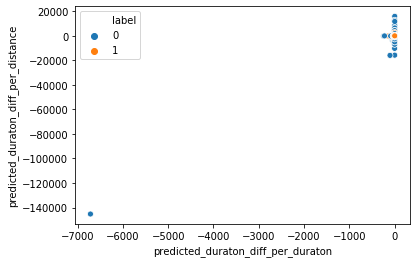

In [138]:
sns.scatterplot(x='predicted_duraton_diff_per_duraton',y='predicted_duraton_diff_per_distance',data=train_df,hue='label')

In [139]:
train_df['predicted_duraton_diff_per_duraton@predicted_duraton_diff_per_distance'] = train_df['predicted_duraton_diff_per_duraton'] * train_df['predicted_duraton_diff_per_distance']
test_df['predicted_duraton_diff_per_duraton@predicted_duraton_diff_per_distance'] = test_df['predicted_duraton_diff_per_duraton'] * test_df['predicted_duraton_diff_per_distance']

In [140]:
def normalize_diff(col_name):
    normalizer = StandardScaler()
    normalizer.fit(train_df[train_df['label'] == 1][col_name].values.reshape(-1,1))

    train_df[f'{col_name}_normalized'] = normalizer.transform(train_df[col_name].values.reshape(-1,1))
    test_df[f'{col_name}_normalized'] = normalizer.transform(test_df[col_name].values.reshape(-1,1))

In [141]:
diff_cols = [
    'predicted_fare_diff',
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_predicted_fare', 
    'predicted_fare_diff_per_distance',
    'predicted_duraton_diff_per_duraton',
    'predicted_duraton_diff_per_predicted_duration', 
    'predicted_fare_per_duration_diff',
    'predicted_avg_speed_diff',
    'predicted_meter_waiting_diff',
    'predicted_meter_waiting_diff_per_meter_waiting',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting',
    'predicted_meter_waiting_per_duration_diff',
    'predicted_meter_waiting_fare_diff',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare',
    'predicted_meter_waiting_fare_per_meter_waiting_diff',
    'predicted_meter_waiting_fare_per_duration_diff',
    'predicted_additional_fare_diff',
    'predicted_additional_fare_diff_per_additional_fare'
]
for col in diff_cols:
    normalize_diff(col)

### Group by features

In [142]:
train_df.groupby(['pick_cluster']).mean()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_date,pickup_hour,pickup_minute,drop_date,...,predicted_meter_waiting_diff_per_meter_waiting_normalized,predicted_meter_waiting_diff_per_predicted_meter_waiting_normalized,predicted_meter_waiting_per_duration_diff_normalized,predicted_meter_waiting_fare_diff_normalized,predicted_meter_waiting_fare_diff_per_meter_waiting_fare_normalized,predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare_normalized,predicted_meter_waiting_fare_per_meter_waiting_diff_normalized,predicted_meter_waiting_fare_per_duration_diff_normalized,predicted_additional_fare_diff_normalized,predicted_additional_fare_diff_per_additional_fare_normalized
pick_cluster,,,,,,,,,,,,,,,,,,,,,
0,13.601702,1799.577315,678.154561,34.540466,109.811030,324.336493,15.790635,13.742282,29.442872,15.791190,...,-0.051006,-0.006181,1.559723,-0.115710,-0.067360,0.004542,-0.032194,3.013900,0.072486,-0.033501
1,14.708364,1106.290893,299.945623,14.973657,125.404067,246.266804,16.322281,14.122458,29.760831,16.324492,...,-0.036662,0.013036,0.059489,0.163078,0.186655,-0.019858,-0.149738,0.281444,0.204743,0.204101
2,11.986207,1552.027586,746.986207,41.267152,144.944828,250.860379,15.668966,14.331034,29.468966,15.679310,...,-0.113336,0.002054,-0.014188,0.174445,0.238492,-0.007325,0.064330,0.236657,-0.041575,0.093130


In [143]:
def mean_value(col):
    grouping_order = ['pick_cluster','pickup_timeslot']
    group = train_df[train_df['label'] == 1].groupby(grouping_order)[col].mean()
    def f(row):
        return group[row['pick_cluster']][row['pickup_timeslot']]
    return f

In [144]:
def mean_encoding(col):
    train_df[f'{col}_mean'] = train_df.apply(mean_value(col),axis=1)
    test_df[f'{col}_mean'] = test_df.apply(mean_value(col),axis=1)
    
    train_df[f'{col}_mean_diff'] = train_df[f'{col}_mean'] - train_df[col]
    test_df[f'{col}_mean_diff'] = test_df[f'{col}_mean'] - test_df[col]

In [145]:
mean_cols = [
    'fare_per_distance',
    'avg_speed', 
    'meter_waiting_per_duration', 
    'meter_waiting_fare_per_meter_waiting',
    'meter_waiting_fare_per_duration',
    'addtional_fare_per_fare',
    'addtional_fare_per_distance', 
    'addtional_fare_per_duration'
]
for col in mean_cols:
    mean_encoding(col)

In [146]:
train_df.to_csv('train_df_final.csv',index=False)
test_df.to_csv('test_df_final.csv',index=False)

## Difference binning

In [147]:
cols = [
    'predicted_fare_diff',
    'predicted_duration_diff',
    'predicted_meter_waiting_diff',
    'predicted_meter_waiting_fare_diff',
    'predicted_additional_fare_diff',    
]

In [148]:
def col_bucket(column):
    std = train_df[train_df['label']==1][column].std()
    name = f'{column}_bucket'
    train_df[name] = np.round((train_df[column]/std)+1).astype(int)
    test_df[name] = np.round((test_df[column]/std)+1).astype(int)    

In [149]:
for each in cols:
    col_bucket(each)

In [150]:
bin_multiplicatives = {
    'predicted_fare_diff_bucket':[
        'fare',
        'predicted_fare',
        'fare_per_distance',
        'predicted_fare_per_distance',         
    ],
    'predicted_duration_diff_bucket':[
        'duration',
        'predicted_duration',
        'avg_speed', 
        'predicted_avg_speed',         
    ],
    'predicted_meter_waiting_diff_bucket':[
        'meter_waiting', 
        'predicted_meter_waiting', 
        'meter_waiting_per_duration', 
        'predicted_meter_waiting_per_duration',
    ],
    'predicted_meter_waiting_fare_diff_bucket':[
        'meter_waiting_fare',
        'predicted_meter_waiting_fare',
        'meter_waiting_fare_per_meter_waiting',
        'predicted_meter_waiting_fare_per_meter_waiting',
        'meter_waiting_fare_per_duration',
        'predicted_meter_waiting_fare_per_duration',
    ],
    'predicted_additional_fare_diff':[
        'additional_fare',
        'predicted_additional_fare', 
        'predicted_addtional_fare_per_fare', 
        'addtional_fare_per_fare',
        'addtional_fare_per_distance', 
        'predicted_addtional_fare_per_distance',
        'addtional_fare_per_duration', 
        'predicted_addtional_fare_per_duration',
    ]
    
}

In [151]:
for bucket in tqdm(bin_multiplicatives):
    for col in bin_multiplicatives[bucket]:
        name = f'{bucket}@{col}'
        train_df[name] = train_df[bucket] * train_df[col]
        test_df[name] = test_df[bucket] * test_df[col]

100%|██████████| 5/5 [00:00<00:00, 109.44it/s]


In [152]:
train_df.to_csv('train_df_final.csv',index=False)
test_df.to_csv('test_df_final.csv',index=False)

In [186]:
[each for each in train_df.columns if '@' in each]

['predicted_duraton_diff_per_duraton@predicted_duraton_diff_per_distance',
 'predicted_fare_diff_bucket@fare',
 'predicted_fare_diff_bucket@predicted_fare',
 'predicted_fare_diff_bucket@fare_per_distance',
 'predicted_fare_diff_bucket@predicted_fare_per_distance',
 'predicted_duration_diff_bucket@duration',
 'predicted_duration_diff_bucket@predicted_duration',
 'predicted_duration_diff_bucket@avg_speed',
 'predicted_duration_diff_bucket@predicted_avg_speed',
 'predicted_meter_waiting_diff_bucket@meter_waiting',
 'predicted_meter_waiting_diff_bucket@predicted_meter_waiting',
 'predicted_meter_waiting_diff_bucket@meter_waiting_per_duration',
 'predicted_meter_waiting_diff_bucket@predicted_meter_waiting_per_duration',
 'predicted_meter_waiting_fare_diff_bucket@meter_waiting_fare',
 'predicted_meter_waiting_fare_diff_bucket@predicted_meter_waiting_fare',
 'predicted_meter_waiting_fare_diff_bucket@meter_waiting_fare_per_meter_waiting',
 'predicted_meter_waiting_fare_diff_bucket@predicted_me

# Classifier

In [187]:
train_df = pd.read_csv('train_df_final.csv')
test_df = pd.read_csv('test_df_final.csv')
train_df_balanced = pd.read_csv('train_df_final_blanced.csv')

features = [
#     'additional_fare', 
#     'pickup_date', 
#     'pickup_hour',
#     'pickup_minute', 
#     'drop_date', 
#     'drop_hour', 
#     'drop_minute',    
#     'pick_cluster', 
#     'is_more_than_one_day', 
#     'distance_km', 
#     'pickup_timeslot', 
#     'day_of_week', 
#     'is_weekday', 
#     'cal_time_difference',
    # noise columns    
    'meter_waiting', 
    'meter_waiting_fare',
    'fare',
    'predicted_fare',
    'fare_per_distance',
    'predicted_fare_per_distance', 
    'predicted_duration',
    'fare_per_duration',
    'predicted_fare_per_duration',
    'avg_speed', 
    'predicted_avg_speed', 
    'predicted_meter_waiting', 
    'meter_waiting_per_duration', 
    'predicted_meter_waiting_per_duration',
    'predicted_meter_waiting_fare',
    'meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_per_meter_waiting',
    'meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_per_duration',
    'predicted_additional_fare', 
    'predicted_addtional_fare_per_fare', 
    'addtional_fare_per_fare',
    'addtional_fare_per_distance', 
    'predicted_addtional_fare_per_distance',
    'addtional_fare_per_duration', 
    'predicted_addtional_fare_per_duration',
    
#     'predicted_duraton_diff_per_duraton@predicted_duraton_diff_per_distance',
#     'predicted_fare_diff_normalized',
#     'predicted_fare_diff_per_fare_normalized',
#     'predicted_fare_diff_per_predicted_fare_normalized', 
#     'predicted_fare_diff_per_distance_normalized',
#     'predicted_duraton_diff_per_duraton_normalized',
#     'predicted_duraton_diff_per_predicted_duration_normalized', 
#     'predicted_fare_per_duration_diff_normalized',
#     'predicted_avg_speed_diff_normalized',
#     'predicted_meter_waiting_diff_normalized',
#     'predicted_meter_waiting_diff_per_meter_waiting_normalized',
#     'predicted_meter_waiting_diff_per_predicted_meter_waiting_normalized',
#     'predicted_meter_waiting_per_duration_diff_normalized',
#     'predicted_meter_waiting_fare_diff_normalized',
#     'predicted_meter_waiting_fare_diff_per_meter_waiting_fare_normalized',
#     'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare_normalized',
#     'predicted_meter_waiting_fare_per_meter_waiting_diff_normalized',
#     'predicted_meter_waiting_fare_per_duration_diff_normalized',
#     'predicted_additional_fare_diff_normalized',
#     'predicted_additional_fare_diff_per_additional_fare_normalized',
    
#     'fare_per_distance_mean',
#     'avg_speed_mean', 
#     'meter_waiting_per_duration_mean', 
#     'meter_waiting_fare_per_meter_waiting_mean',
#     'meter_waiting_fare_per_duration_mean',
#     'addtional_fare_per_fare_mean',
#     'addtional_fare_per_distance_mean', 
#     'addtional_fare_per_duration_mean', 

#     'fare_per_distance_mean_diff',
#     'avg_speed_mean_diff', 
#     'meter_waiting_per_duration_mean_diff', 
#     'meter_waiting_fare_per_meter_waiting_mean_diff',
#     'meter_waiting_fare_per_duration_mean_diff',
#     'addtional_fare_per_fare_mean_diff',
#     'addtional_fare_per_distance_mean_diff', 
#     'addtional_fare_per_duration_mean_diff',
    'predicted_fare_diff_bucket',
    'predicted_duration_diff_bucket',   
    'predicted_meter_waiting_diff_bucket',
    'predicted_meter_waiting_fare_diff_bucket',
    'predicted_additional_fare_diff_bucket',
    'predicted_fare_diff_bucket@fare',
    'predicted_fare_diff_bucket@predicted_fare',
    'predicted_fare_diff_bucket@fare_per_distance',
    'predicted_fare_diff_bucket@predicted_fare_per_distance',
    'predicted_duration_diff_bucket@duration',
    'predicted_duration_diff_bucket@predicted_duration',
    'predicted_duration_diff_bucket@avg_speed',
    'predicted_duration_diff_bucket@predicted_avg_speed',
    'predicted_meter_waiting_diff_bucket@meter_waiting',
    'predicted_meter_waiting_diff_bucket@predicted_meter_waiting',
    'predicted_meter_waiting_diff_bucket@meter_waiting_per_duration',
    'predicted_meter_waiting_diff_bucket@predicted_meter_waiting_per_duration',
    'predicted_meter_waiting_fare_diff_bucket@meter_waiting_fare',
    'predicted_meter_waiting_fare_diff_bucket@predicted_meter_waiting_fare',
    'predicted_meter_waiting_fare_diff_bucket@meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_diff_bucket@predicted_meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_diff_bucket@meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_diff_bucket@predicted_meter_waiting_fare_per_duration',
    'predicted_additional_fare_diff@additional_fare',
    'predicted_additional_fare_diff@predicted_additional_fare',
    'predicted_additional_fare_diff@predicted_addtional_fare_per_fare',
    'predicted_additional_fare_diff@addtional_fare_per_fare',
    'predicted_additional_fare_diff@addtional_fare_per_distance',
    'predicted_additional_fare_diff@predicted_addtional_fare_per_distance',
    'predicted_additional_fare_diff@addtional_fare_per_duration',
    'predicted_additional_fare_diff@predicted_addtional_fare_per_duration'
]

In [188]:
cat_features = [
    'predicted_fare_diff_bucket',
    'predicted_duration_diff_bucket',
    'predicted_meter_waiting_diff_bucket',
    'predicted_meter_waiting_fare_diff_bucket',
    'predicted_additional_fare_diff_bucket',
]

In [189]:
labels = train_df['label'].values
train_df = train_df.drop(['label'], axis=1)[features]

In [190]:
class_weights = [(labels.shape[0] - np.sum(labels)) / np.sum(labels),1]

In [196]:
params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
#     'class_weights':class_weights,
    'border_count':512,
#     'depth':6,
}

In [197]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
train_df_balaned_pool = Pool(data=train_df_balanced[features], cat_features=cat_features)
y_balaned = train_df_balanced['label'].values

In [198]:
skf = StratifiedKFold(n_splits=3)

validation_scores = []
balanced_socores = []
submission_preds = np.zeros(submission_df.shape[0])
train_pools = []
models = []
for train_index, test_index in skf.split(train_df, labels):
    X_train, X_test = train_df.iloc[train_index,:], train_df.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_scores.append(f1_score(y_test,pred,average='micro'))
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)
    balanced_socores.append(f1_score(y_balaned,model.predict(train_df_balaned_pool),average='micro'))

Learning rate set to 0.057693
0:	learn: 0.9699083	test: 0.9655303	best: 0.9655303 (0)	total: 24.2ms	remaining: 24.2s
10:	learn: 0.9726047	test: 0.9750693	best: 0.9750693 (10)	total: 224ms	remaining: 20.1s
20:	learn: 0.9745795	test: 0.9768199	best: 0.9768199 (20)	total: 423ms	remaining: 19.7s
30:	learn: 0.9759434	test: 0.9777607	best: 0.9778545 (29)	total: 629ms	remaining: 19.7s
40:	learn: 0.9763636	test: 0.9778502	best: 0.9782379 (34)	total: 888ms	remaining: 20.8s
50:	learn: 0.9769647	test: 0.9783068	best: 0.9783151 (44)	total: 1.08s	remaining: 20.1s
60:	learn: 0.9772989	test: 0.9783965	best: 0.9784905 (55)	total: 1.33s	remaining: 20.6s
70:	learn: 0.9778119	test: 0.9783841	best: 0.9786784 (61)	total: 1.52s	remaining: 19.9s
80:	learn: 0.9782379	test: 0.9787602	best: 0.9787602 (78)	total: 1.73s	remaining: 19.6s
90:	learn: 0.9788928	test: 0.9788543	best: 0.9788543 (89)	total: 1.92s	remaining: 19.1s
100:	learn: 0.9795135	test: 0.9787602	best: 0.9789524 (92)	total: 2.12s	remaining: 18.9s
11

In [199]:
np.mean(validation_scores), np.std(validation_scores), np.min(validation_scores)

(0.9573874638316427, 0.004905950354905985, 0.9504862953138815)

In [200]:
np.mean(balanced_socores), np.std(balanced_socores), np.min(balanced_socores)

(0.9574002648091646, 0.0007564486152947097, 0.9566518910828392)

In [29]:
submission_df['prediction'] = np.where(submission_preds > 2, 1, 0)
submission_df.to_csv('submission.csv',index=False)

In [30]:
best_model = models[np.argmax(validation_scores)]

In [31]:
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,predicted_fare_per_duration,16.366160
1,fare_per_distance,12.444706
2,predicted_duration_diff_bucket,8.545739
3,fare_per_duration,8.193088
4,predicted_meter_waiting_per_duration,7.083602
5,fare,6.776003
6,predicted_fare_per_distance,5.456525
7,predicted_additional_fare,3.905076
8,avg_speed,3.338793
9,meter_waiting_per_duration,3.109465


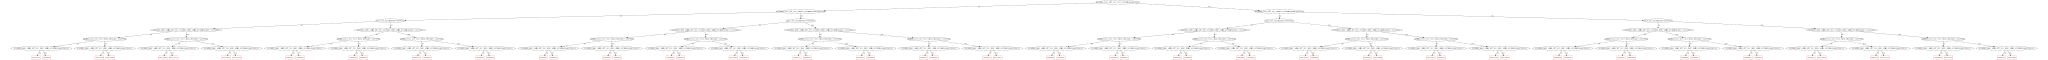

In [415]:
best_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

In [416]:
worst_model = models[np.argmin(validation_scores)]

In [417]:
worst_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,predicted_fare_diff_per_predicted_fare_normalized,11.262931
1,predicted_duraton_diff_per_duraton@predicted_d...,9.561961
2,predicted_fare_diff_per_distance_normalized,7.274241
3,predicted_fare_diff_normalized,5.764607
4,fare_per_duration,4.895544
5,predicted_additional_fare_diff_per_additional_...,4.531051
6,fare_per_distance,4.129538
7,predicted_fare_per_distance,3.648430
8,predicted_additional_fare_diff_normalized,2.683112
9,fare_per_distance_mean_diff,2.538554


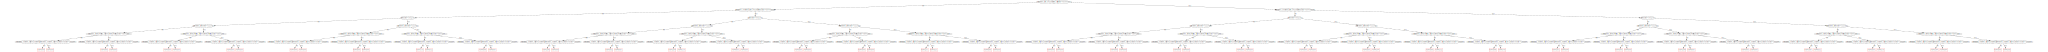

In [285]:
worst_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

In [286]:
cv_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'verbose': False
}

In [ ]:
cv_pool = Pool(data=train_df,label=labels)

In [ ]:
scores = cv(cv_pool,cv_params,plot=True, fold_count=3)

In [ ]:
def filter_features(features):
    features_to_drop = []
    features_to_keep = []
    for feature in features:
        if feature in features_to_drop:
            continue
        highly_corr_features = list((np.array(features))[np.abs(train_df[features].corr()[feature]) > 0.8])
        for each in highly_corr_features:
            if each == feature or each in features_to_keep:
                continue
            else:
                features_to_drop.append(each)
        features_to_keep.append(feature)
    return features_to_keep

In [ ]:
f = list(best_model.get_feature_importance(prettified=True)['Feature Id'].values)
new_features = filter_features(f)

In [ ]:
sns.heatmap(train_df[new_features].corr())

In [ ]:
train_df = train_df[new_features]

In [ ]:
submission_pool = Pool(data=test_df[new_features])

In [ ]:
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_pools = []
models = []
for train_index, test_index in skf.split(train_df, labels):
    X_train, X_test = train_df.iloc[train_index,:], train_df.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train_pool = Pool(data=X_train, label=y_train)
    test_pool = Pool(data=X_test, label=y_test)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)
    train_preds += model.predict_proba(train_df_pool)[:,1]
    test_preds += model.predict_proba(submission_pool)[:,1]

In [ ]:
np.mean(validation_scores), np.std(validation_scores)

In [ ]:
stacking_train_df['catboost_low_corr'] = train_preds

stacking_test_df['catboost_low_corr'] = submission_preds

In [ ]:
stacking_train_df.to_csv('stacking_train_df.csv',index=False)
stacking_test_df.to_csv('stacking_test_df.csv',index=False)

In [ ]:
submission_df['prediction'] = np.where(submission_preds > 2, 1, 0)
submission_df.to_csv('submission_filtered.csv',index=False)

In [ ]:
best_model = models[np.argmax(validation_scores)]

In [ ]:
best_model.get_feature_importance(prettified=True)

In [ ]:
best_model.plot_tree(0,train_pools[np.argmax(validation_scores)])

In [ ]:
cv_pool = Pool(data=train_df,label=labels)

In [ ]:
scores = cv(cv_pool,cv_params,plot=True, fold_count=3)